In [20]:
# Import modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import utils.data_preprocessor as dp
from importlib import reload
from sklearn.preprocessing import StandardScaler
import utils.data_wrangling as wr
import utils.data_transformation as tr
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import utils.lasso_regression as lr
import utils.gradient_boost_regression as gb
import utils.LSTM as lstm
import utils.eda_visuals as viz
from sklearn.linear_model import Ridge
import utils.model_training as mlt
import utils.standardization_and_pca as spca
import utils.prophet as pht
import utils.ARIMA_Model as arima
from scipy.stats import skew
# add reload to ensure we have latest working version in cache
modules = [mlt, dp, wr, tr, lr, gb, lstm, viz, spca, pht, arima]
for module in modules:
    reload(module)



In [2]:

# Reading in the csv files
stock_data = dp.read_data('data/stock_data.csv')
unemployment = dp.read_data('data/SeriesReport.csv')

In [3]:
# Print list of missing values per column and preview of df
dp.print_missing(stock_data)
stock_data.head()

dt has 0 missing values
vix has 0 missing values
sp500 has 0 missing values
sp500_volume has 0 missing values
djia has 0 missing values
djia_volume has 0 missing values
hsi has 0 missing values
ads has 0 missing values
us3m has 0 missing values
joblessness has 0 missing values
epu has 0 missing values
GPRD has 0 missing values
prev_day has 0 missing values


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009


In [4]:
# Print list of missing values per column and preview of df
dp.print_missing(unemployment)
unemployment.head()

Year has 0 missing values
Jan has 0 missing values
Feb has 0 missing values
Mar has 0 missing values
Apr has 0 missing values
May has 0 missing values
Jun has 0 missing values
Jul has 0 missing values
Aug has 0 missing values
Sep has 0 missing values
Oct has 0 missing values
Nov has 0 missing values
Dec has 0 missing values


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1990,5.4,5.3,5.2,5.4,5.4,5.2,5.5,5.7,5.9,5.9,6.2,6.3
1,1991,6.4,6.6,6.8,6.7,6.9,6.9,6.8,6.9,6.9,7.0,7.0,7.3
2,1992,7.3,7.4,7.4,7.4,7.6,7.8,7.7,7.6,7.6,7.3,7.4,7.4
3,1993,7.3,7.1,7.0,7.1,7.1,7.0,6.9,6.8,6.7,6.8,6.6,6.5
4,1994,6.6,6.6,6.5,6.4,6.1,6.1,6.1,6.0,5.9,5.8,5.6,5.5


## Exploratory Data Analysis

In [5]:
stock_data = wr.date_transform(stock_data, 'dt')

unemployment_unpivot = wr.unpivot_df(unemployment)

unemployment_unpivot_mapping = wr.mapping_month_names(unemployment_unpivot, 'Month')

stock_data_final = wr.merge_dfs(stock_data, unemployment_unpivot)

# Returning the First Five Records
stock_data_final.head()


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month,Unemployment Percent
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002,1990,1,5.4
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010,1990,1,5.4
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013,1990,1,5.4
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012,1990,1,5.4
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009,1990,1,5.4


In [6]:
# Returning Information on the DataFrame
stock_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   dt                    8597 non-null   datetime64[ns]
 1   vix                   8597 non-null   float64       
 2   sp500                 8597 non-null   float64       
 3   sp500_volume          8597 non-null   float64       
 4   djia                  8597 non-null   float64       
 5   djia_volume           8597 non-null   float64       
 6   hsi                   8597 non-null   float64       
 7   ads                   8597 non-null   float64       
 8   us3m                  8597 non-null   float64       
 9   joblessness           8597 non-null   int64         
 10  epu                   8597 non-null   float64       
 11  GPRD                  8597 non-null   float64       
 12  prev_day              8597 non-null   float64       
 13  Year              

In [7]:
# Returning Descriptive Statistics on the Data
stock_data_final.describe()

,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month,Unemployment Percent
count,8597,8597.000000,8597.000000,8.597000e+03,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000
mean,2007-01-19 10:42:31.866930432,19.560306,1596.652238,2.463780e+09,13662.535273,183.166216,16763.460949,-0.158047,2.690266,2.492381,115.564631,109.435667,1596.111831,2006.551704,6.521345,5.758160
min,1990-01-03 00:00:00,9.140000,295.459991,1.499000e+07,2365.100000,1.590000,2736.600098,-26.418300,0.000000,1.000000,57.202620,9.491598,295.459991,1990.000000,1.000000,3.400000
25%,1998-07-06 00:00:00,13.850000,898.700012,6.467400e+08,8038.570000,63.720000,10722.799805,-0.383563,0.180000,1.000000,85.925868,72.857056,897.989990,1998.000000,4.000000,4.500000
50%,2007-01-22 00:00:00,17.730000,1270.199951,2.521000e+09,10846.290000,177.830000,16803.759766,-0.045977,2.300000,2.000000,106.115769,96.603577,1270.089966,2007.000000,7.000000,5.400000
75%,2015-08-04 00:00:00,22.960000,2058.899902,3.834320e+09,17635.390000,272.590000,22867.330078,0.247940,4.990000,3.000000,137.077404,129.159744,2058.689941,2015.000000,10.000000,6.700000
max,2024-02-16 00:00:00,82.690000,5029.730000,1.145623e+10,38797.900000,922.680000,33154.121094,9.482140,8.260000,4.000000,350.459817,1045.603638,5029.730000,2024.000000,12.000000,14.800000
std,NaN,7.902780,1106.241259,1.847305e+09,9022.864862,133.671305,7350.096474,1.651492,2.296294,1.117501,41.579530,64.568210,1105.710429,9.855177,3.437762,1.748314


In [8]:
# Extracting the Desired Columns
stock_data_sample = stock_data_final.select_dtypes(include = 'number').columns.tolist()

# Creating a Dictionary to Map the Variable Names to
column_name_mapping = {
    'vix': 'Volatility Index (VIX)',
    'us3m': 'U.S. Treasury 3-Month Bond Yield',
    'epu': 'Economic Policy Uncertainty Index',
    'GPRD': 'Geopolitical Risk Index',
    'Unemployment Percent': 'Unemployment Percent',
    'sp500': 'S&P 500 Index',
    'sp500_volume': 'S&P 500 Trading Volume',
    'djia': 'Dow Jones Industrial Average',
    'djia_volume': 'Dow Jones Industrial Average Trading Volume',
    'hsi': 'Hang Seng Index',
    'ads': 'Aruoba-Diebold-Scotti Business Conditions Index',
    'prev_day': 'Previous Day Volatility Index (VIX)',
    'joblessness': 'Unemployment (in Quartiles)'
}

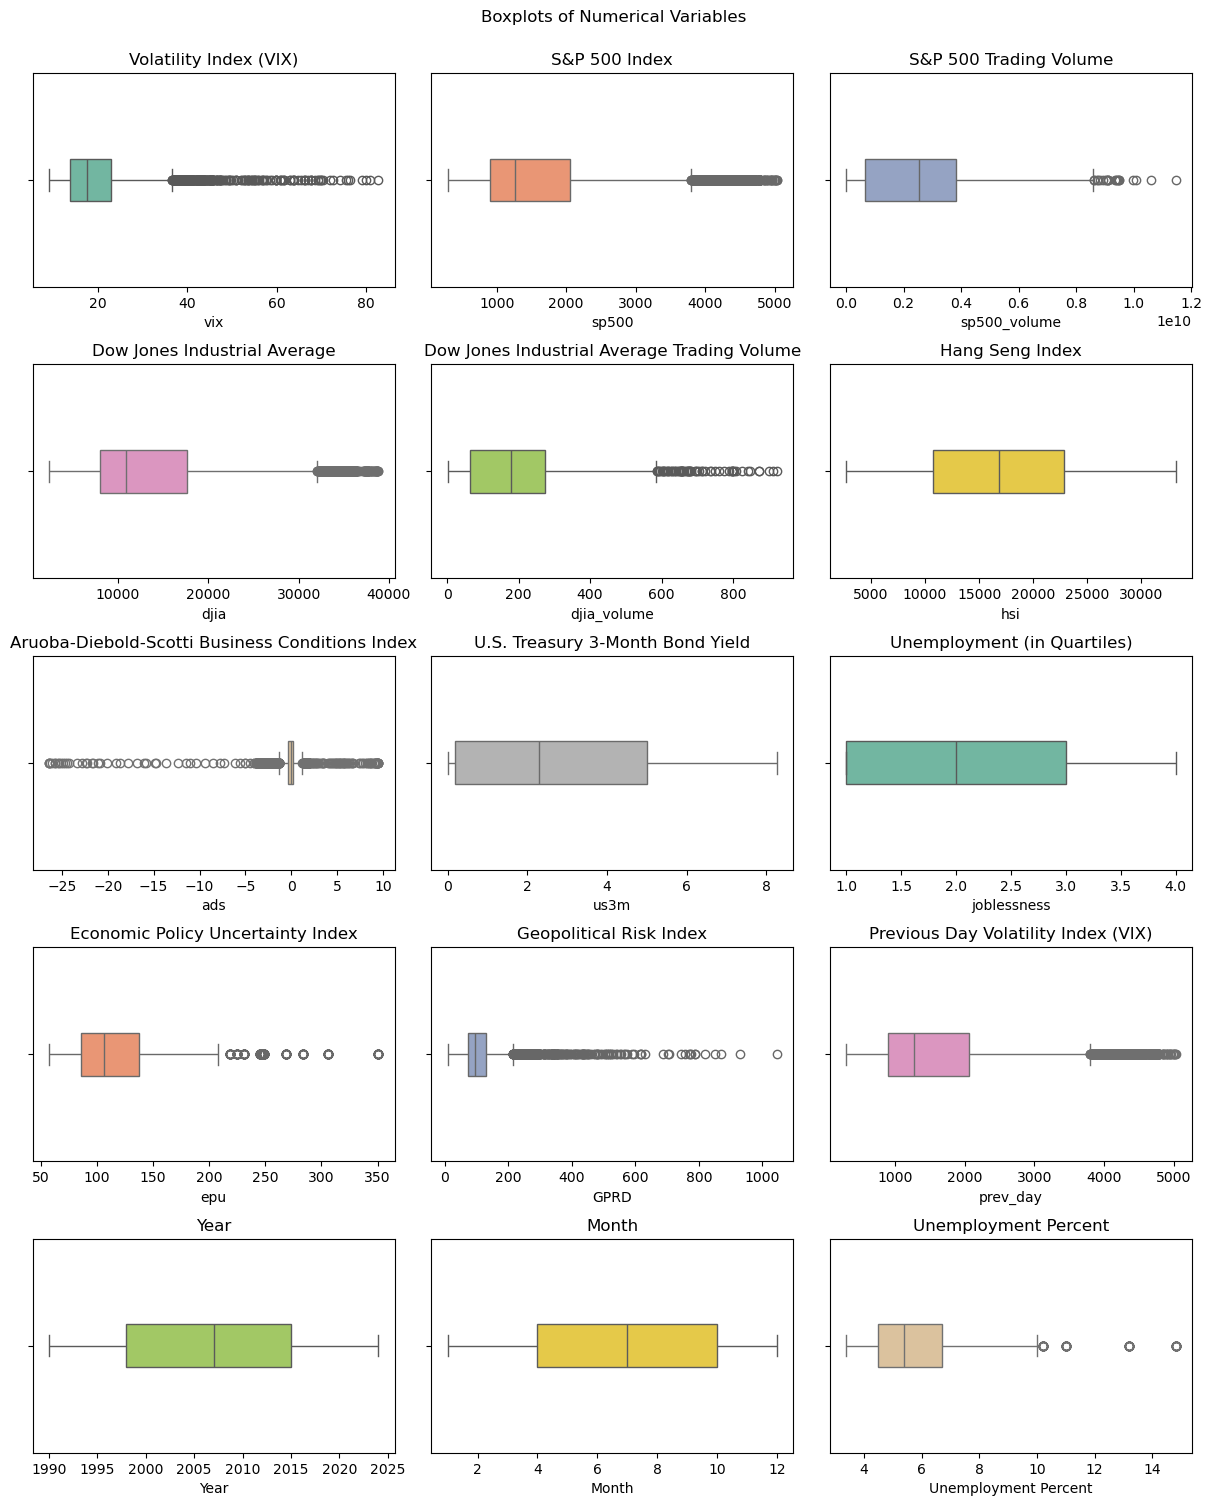

In [11]:
viz.boxplot_visuals(stock_data_final, stock_data_sample, column_name_mapping, 'Boxplots of Numerical Variables')

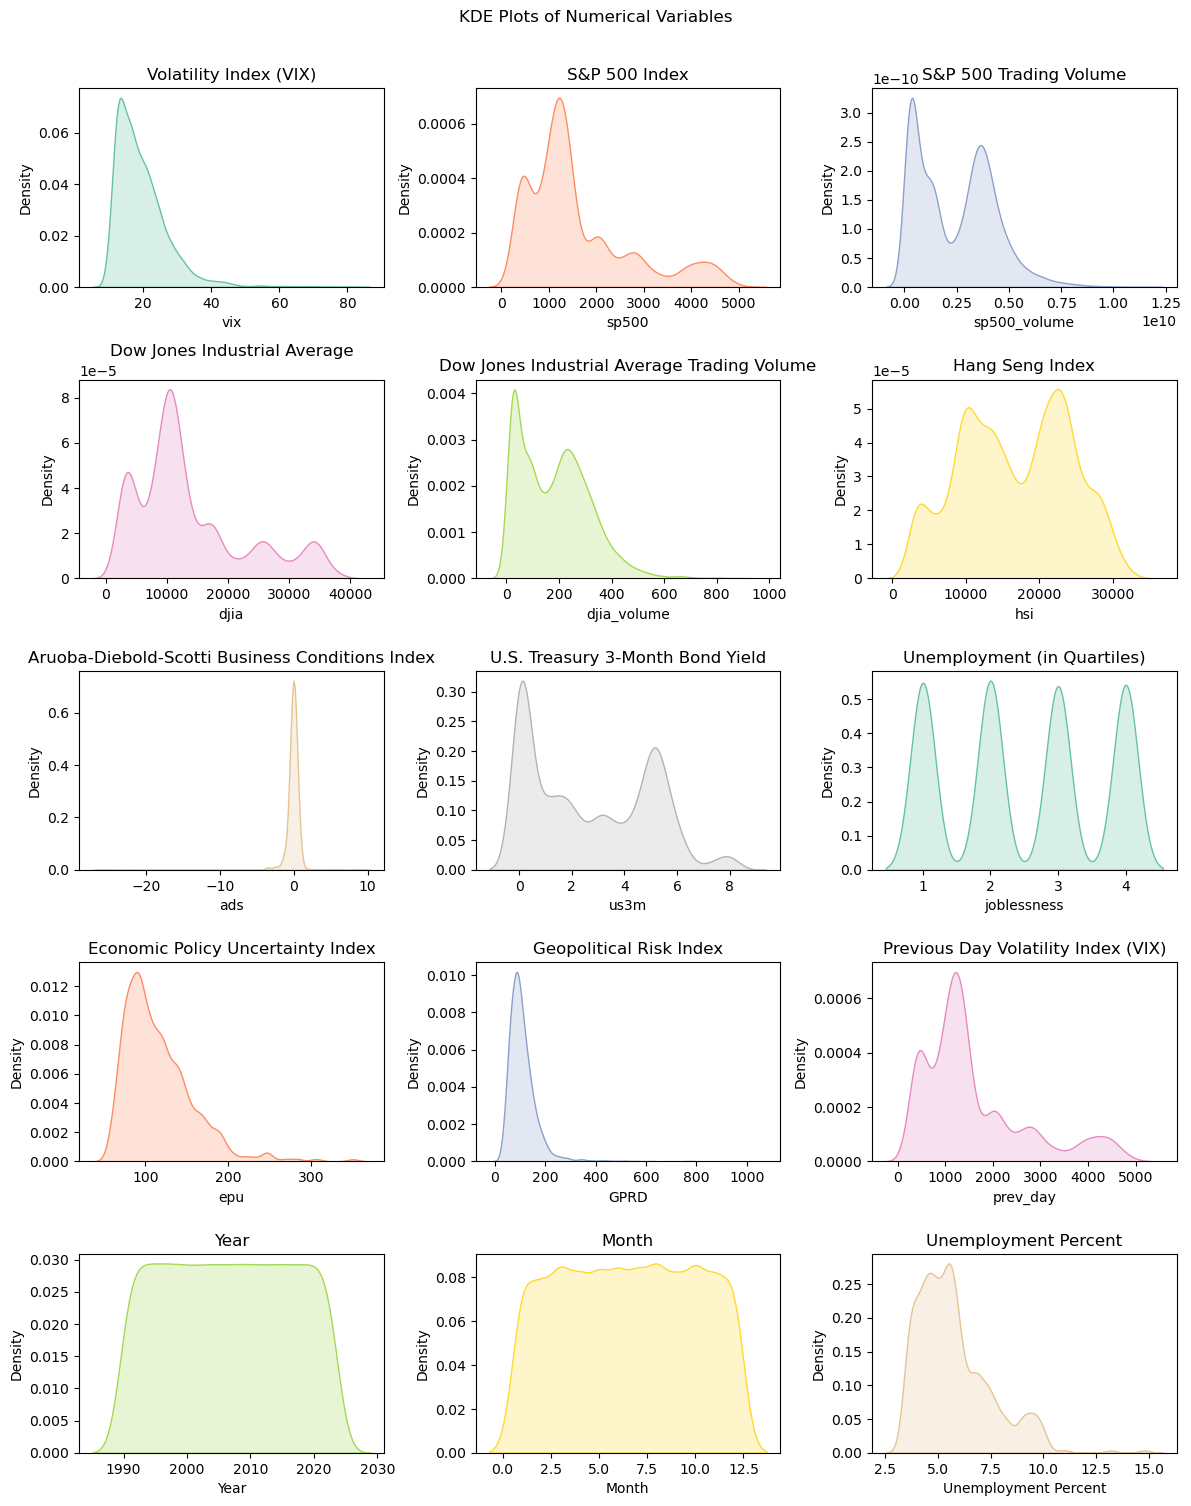

In [12]:
viz.kde_visuals(stock_data_final, stock_data_sample, column_name_mapping, 'KDE Plots of Numerical Variables')

<Figure size 1500x1200 with 0 Axes>

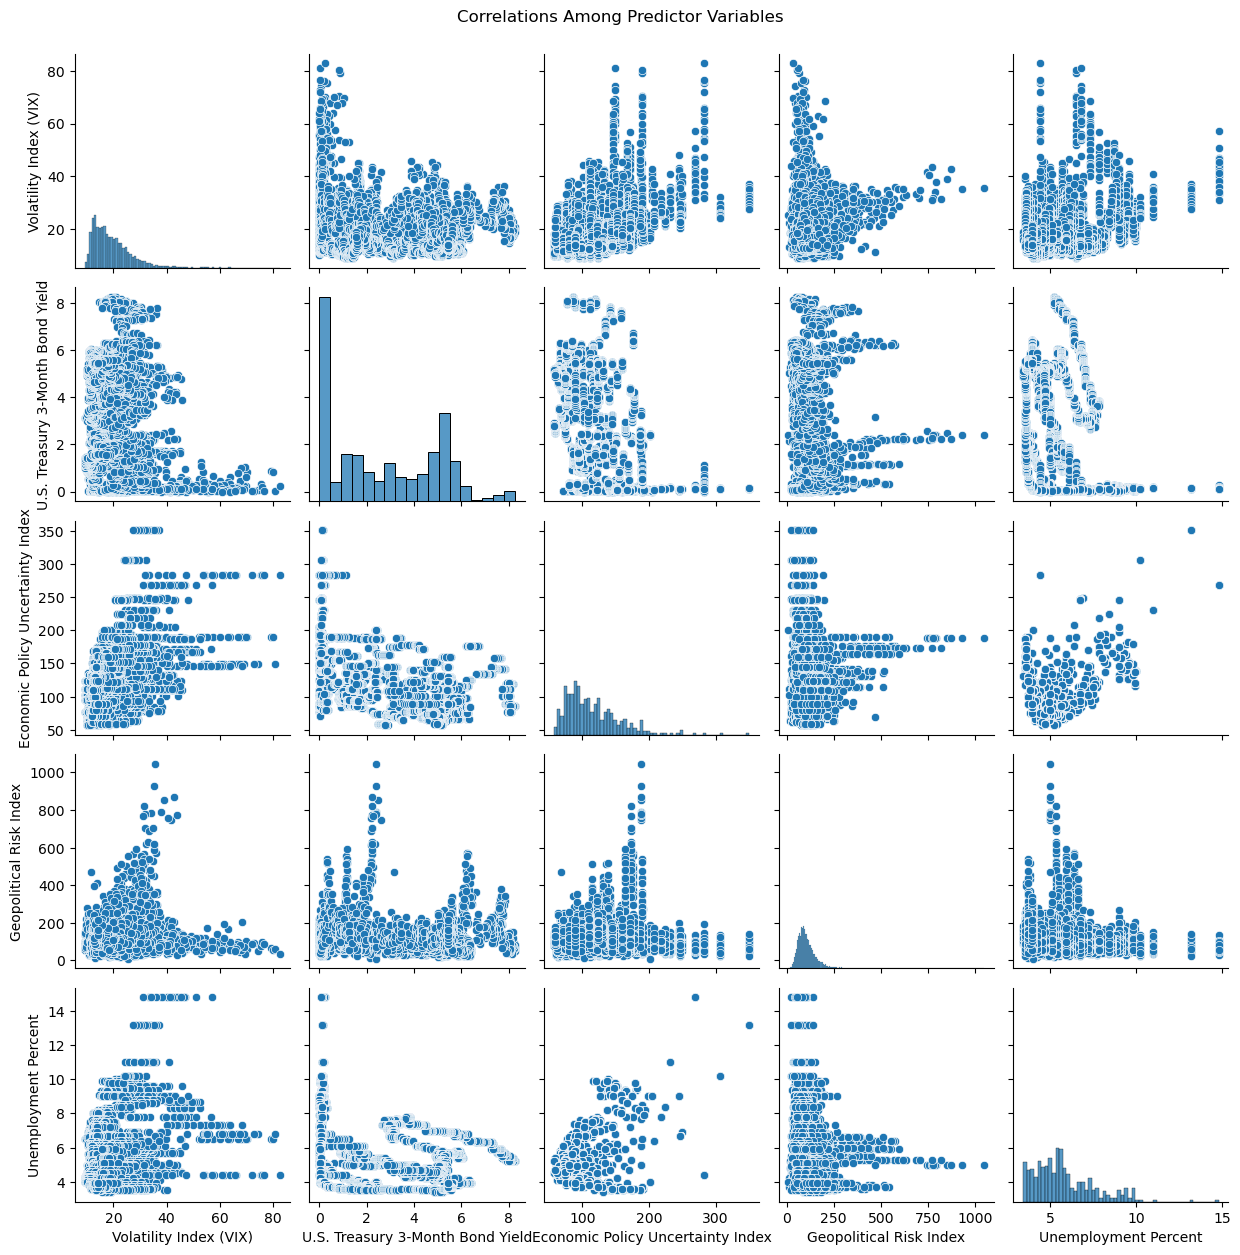

In [18]:
# Creating a Subset of Columns for the Pairplot
stock_data_subset = stock_data_final[['vix', 'us3m', 'epu', 'GPRD', 'Unemployment Percent']]

viz.pairplot_visual(stock_data_subset, column_name_mapping, 'Correlations Among Predictor Variables')

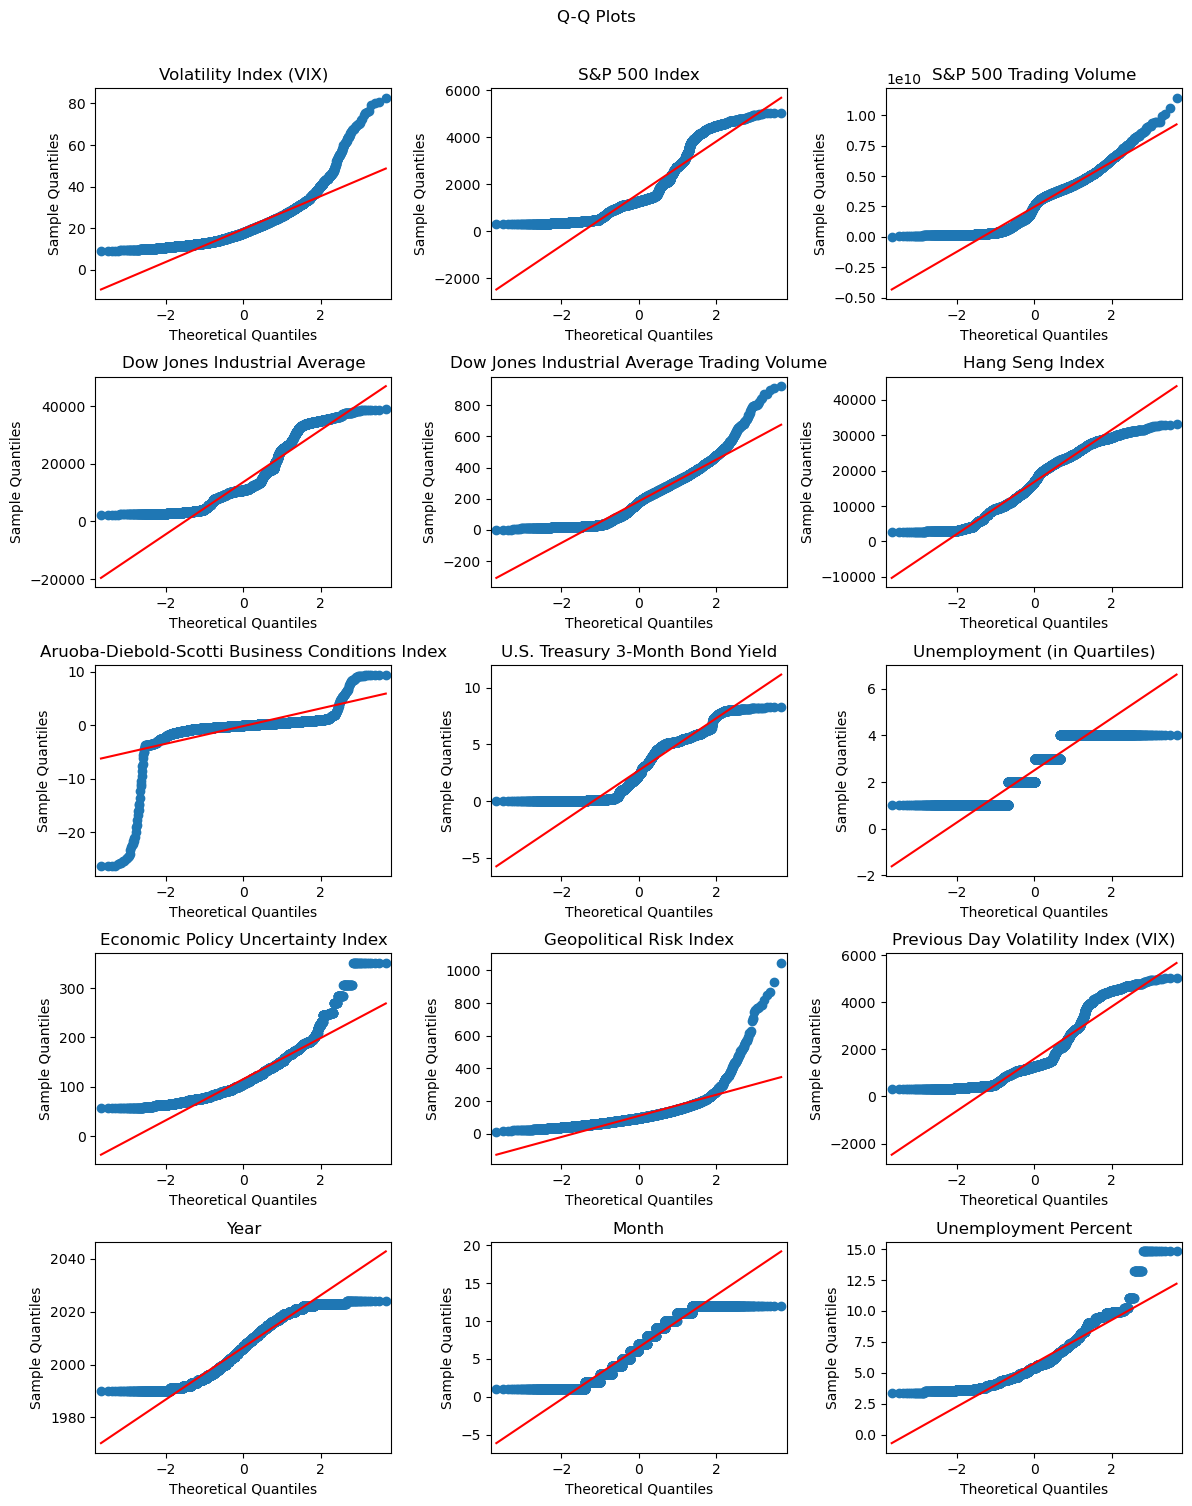

In [74]:
viz.qq_plot(stock_data_final, stock_data_sample, column_name_mapping, 'Q-Q Plots')

### Performing Log Transfomartions

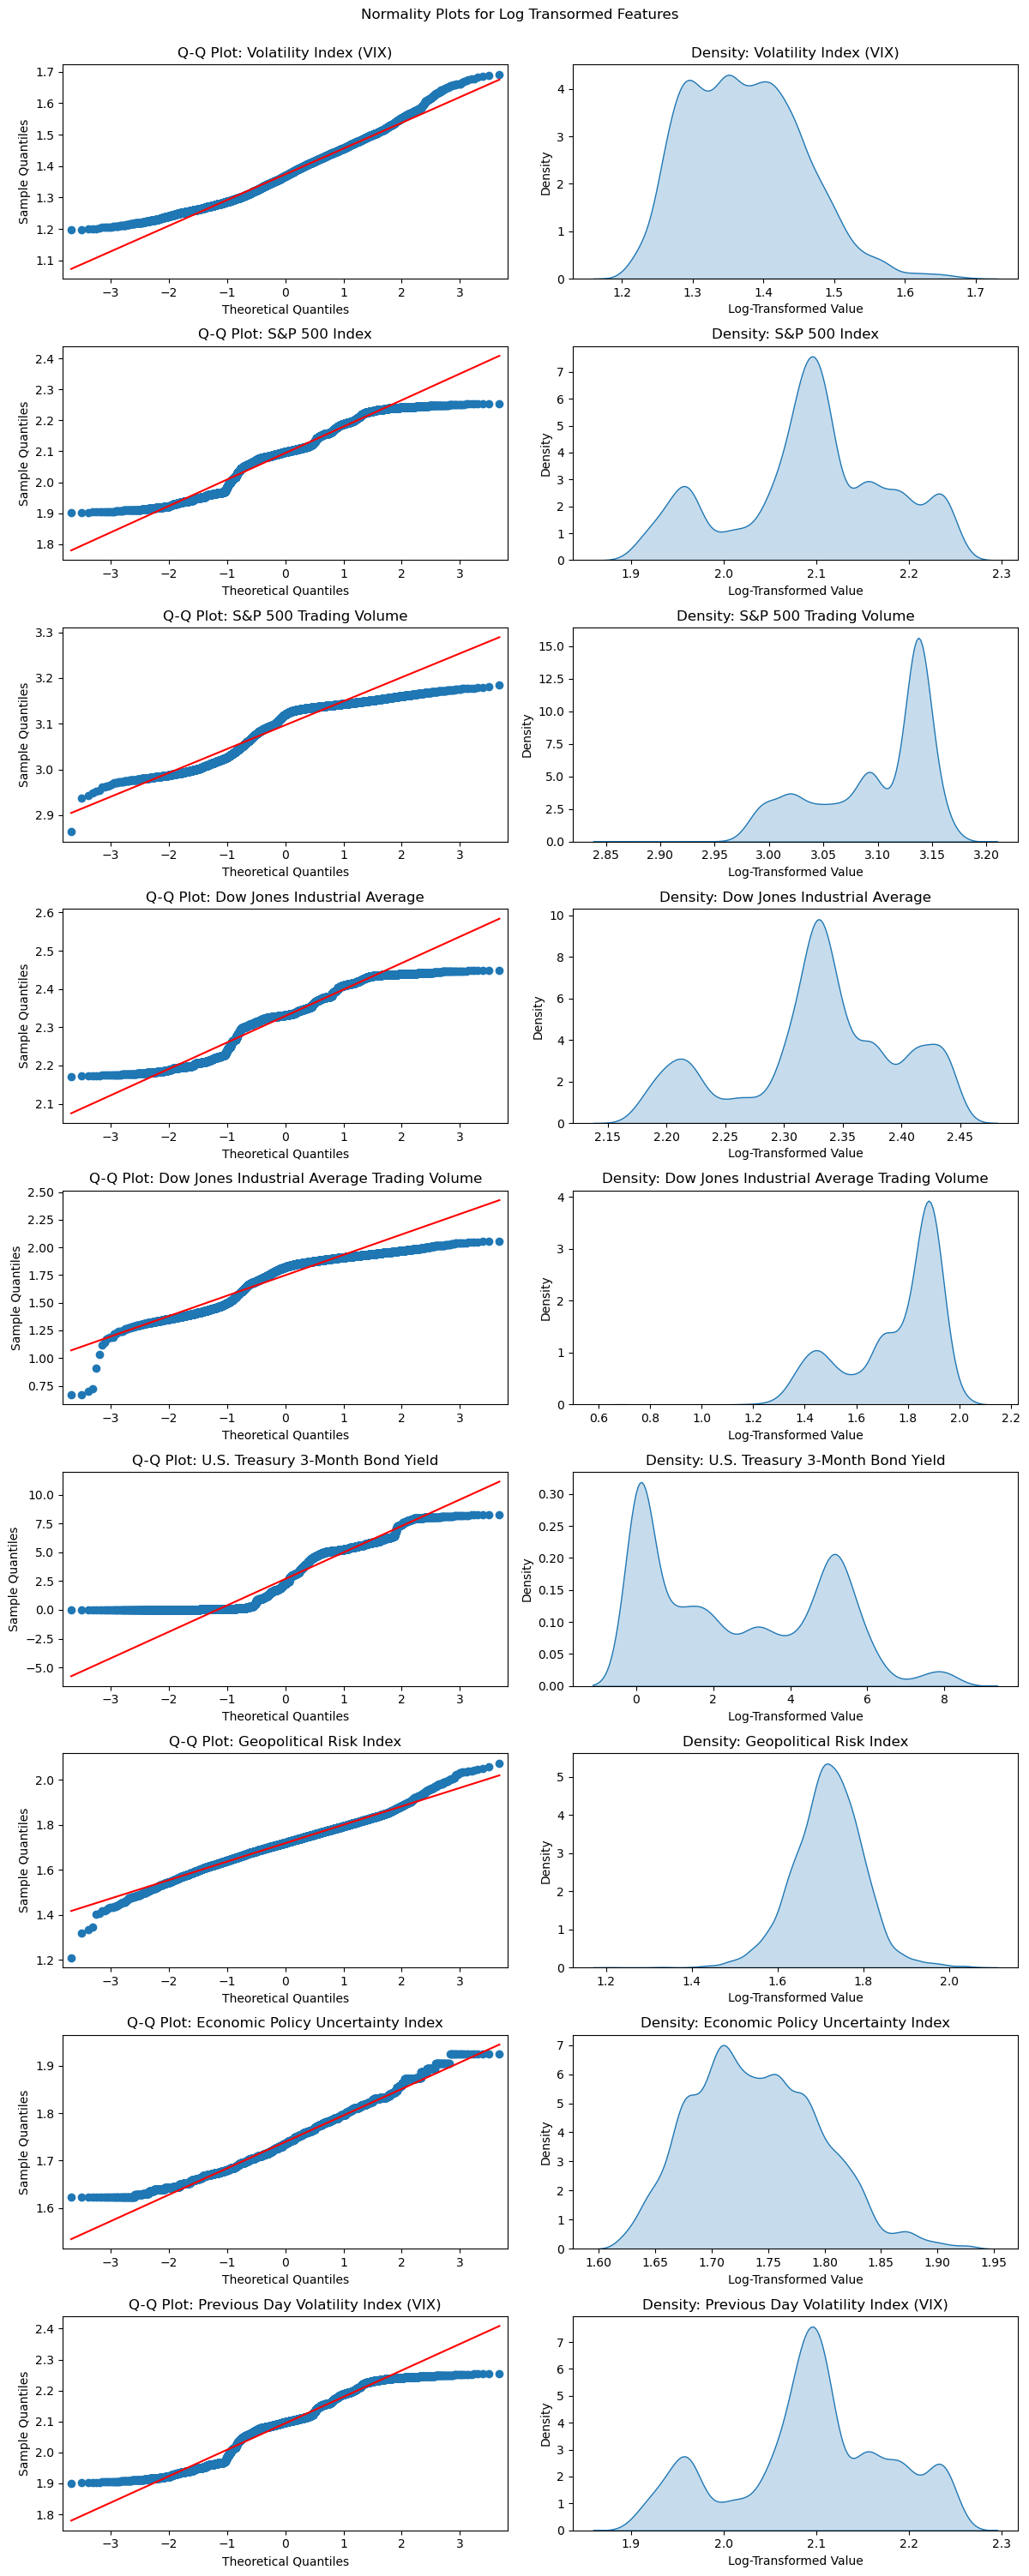

In [21]:
# Initializing a Variable with a Subset of Columns that need to be Log Transformed
numeric_columns_log_transform = stock_data_final[['vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'us3m', 'GPRD', 'epu', 'prev_day']]

stock_data_final = tr.log_transform(stock_data_final, numeric_columns_log_transform, column_name_mapping, 'Normality Plots for Log Transormed Features')


Skewness (scipy) for numeric columns:
vix                     0.682212
sp500                  -0.078829
sp500_volume           -0.704686
djia                   -0.275751
djia_volume            -0.670504
hsi                    -0.067385
ads                    -8.953059
us3m                    0.316291
joblessness             0.013340
epu                     0.491253
GPRD                    0.325277
prev_day               -0.079132
Unemployment Percent    1.216400
dtype: float64


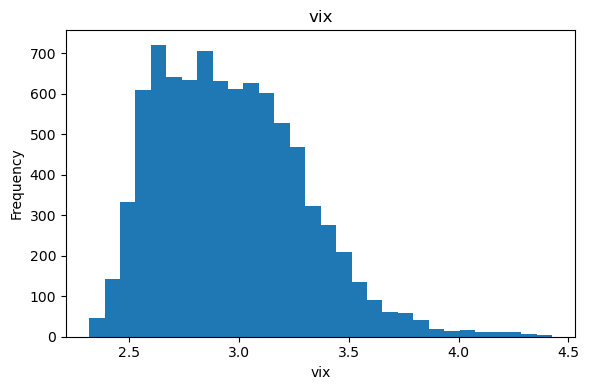

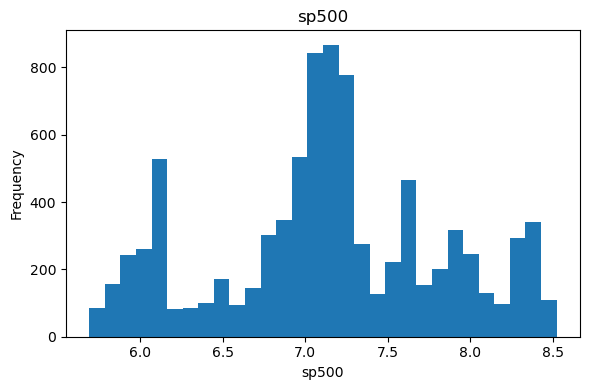

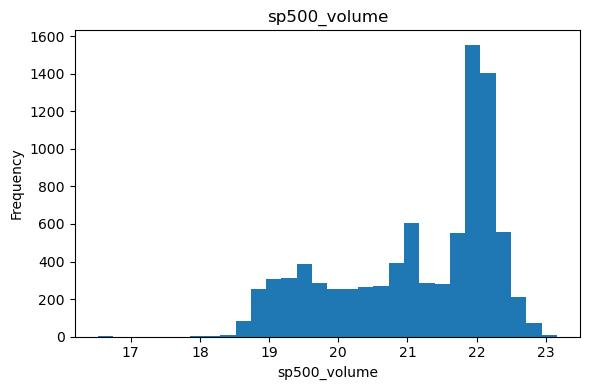

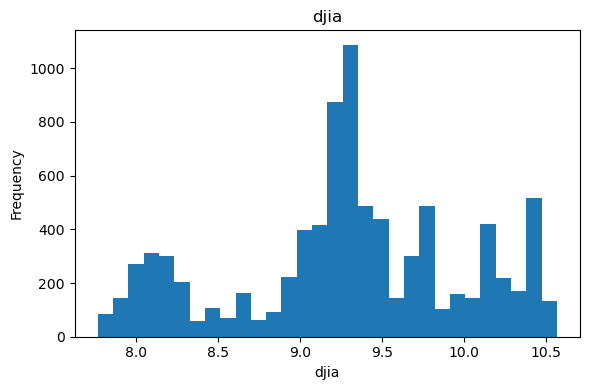

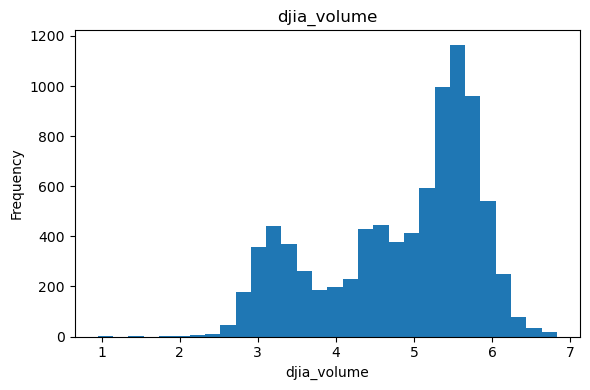

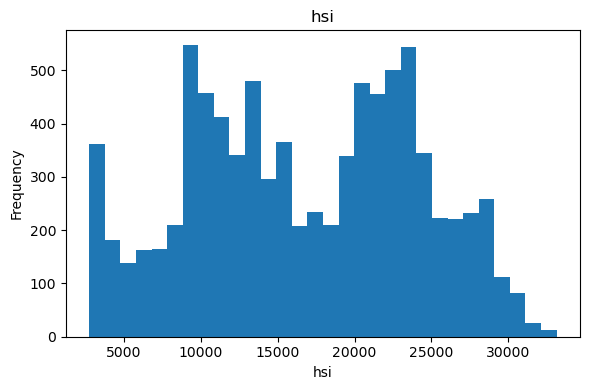

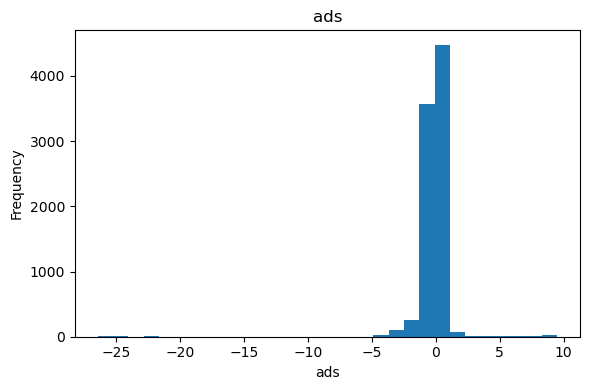

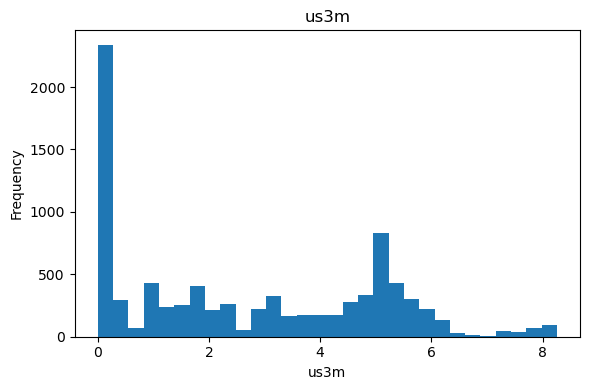

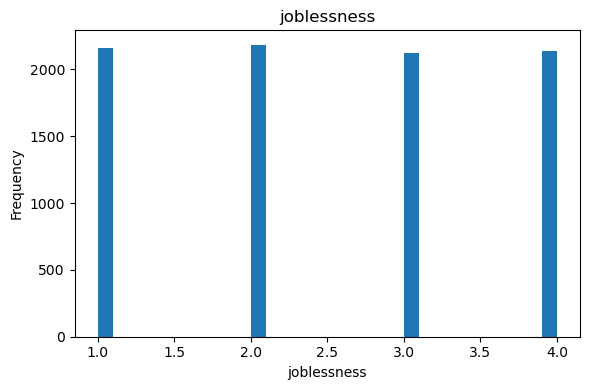

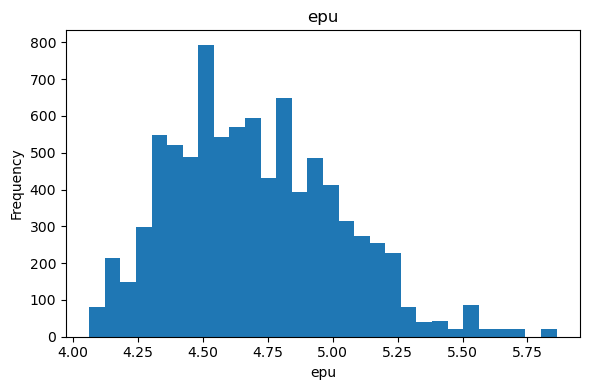

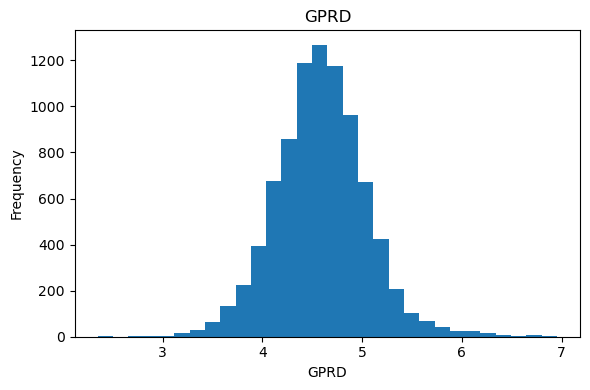

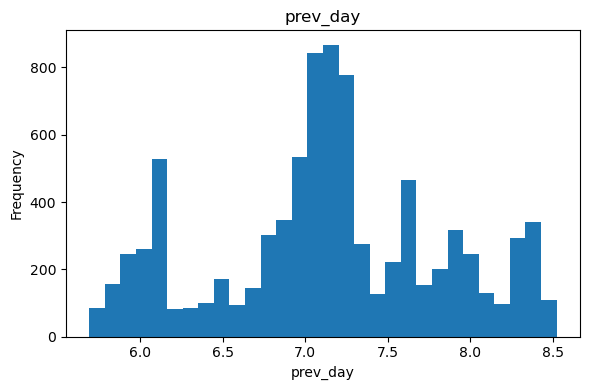

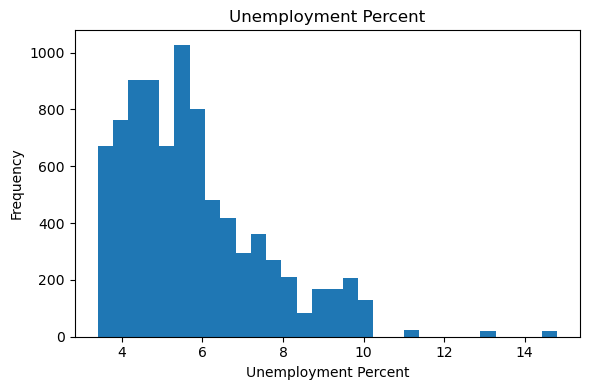


Correlation Matrix:
                           vix     sp500  sp500_volume      djia  djia_volume  \
vix                   1.000000  0.002599      0.157002  0.010845     0.251718   
sp500                 0.002599  1.000000      0.820263  0.995194     0.770390   
sp500_volume          0.157002  0.820263      1.000000  0.857830     0.859878   
djia                  0.010845  0.995194      0.857830  1.000000     0.798656   
djia_volume           0.251718  0.770390      0.859878  0.798656     1.000000   
hsi                  -0.102627  0.835863      0.845692  0.859961     0.667369   
ads                  -0.245727 -0.005274     -0.109540 -0.014028    -0.115079   
us3m                 -0.073731 -0.461556     -0.700034 -0.511047    -0.473849   
joblessness           0.324285 -0.521632     -0.224822 -0.491807    -0.201757   
epu                   0.423868  0.305946      0.412383  0.318633     0.320162   
GPRD                 -0.029405  0.031008      0.048840  0.041886     0.106515   
prev_da

In [76]:

# Initializing a Variable for Categorical and Numerical Columns
categorical_cols = stock_data_final.select_dtypes(include=['object']).columns.tolist()
numerical_cols = stock_data_final.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calculating Skewness for Numerical Columns
numeric_data=stock_data_final[numerical_cols]

skew_array = skew(numeric_data, axis=0, bias=False, nan_policy='omit')
skew_value = pd.Series(skew_array, index=numerical_cols)

print("\nSkewness (scipy) for numeric columns:")
print(skew_value)

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(stock_data_final[col].dropna(), bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#Correlation
corr_matrix = stock_data_final[numerical_cols].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

#sp500 & djia, sp500_volume & djia_volume, are highly correlated (>0.9). 

### Principal Component Analysis

In [78]:
stock_data_final_standardized = spca.standardize_data(stock_data_final, 'vix')

In [79]:
stock_data_final_standardized.isna().sum()

dt                      0
vix                     0
sp500                   0
sp500_volume            0
djia                    0
djia_volume             0
hsi                     0
ads                     0
us3m                    0
joblessness             0
epu                     0
GPRD                    0
prev_day                0
Year                    0
Month                   0
Unemployment Percent    0
dtype: int64

In [80]:
stock_data_final_pca = spca.pca_transformation(stock_data_final_standardized, 'vix', 2)

In [81]:
stock_data_final_pca.head()

,dt,Principal Component 1,Principal Component 2,vix
0,1990-01-03,-5.159501,-0.679943,2.954389
1,1990-01-04,-5.194051,-0.707853,3.006672
2,1990-01-05,-5.287869,-0.699707,3.049747
3,1990-01-08,-5.361367,-0.667460,3.056827
4,1990-01-09,-5.338857,-0.623868,3.144152


### Lasso Regression

In [82]:
# Dropping the Date Columns
stock_data_final_no_date = stock_data_final_standardized.drop(columns = ['dt'])

print('Original Lasso Regression Results:')
print(lr.lasso_regression(stock_data_final_no_date, 'vix', 1.0, 42),'\n')


print('Lasso Regression Results with Hyperparameter Tuning:')
print(lr.lasso_hyperparameter_tuning(stock_data_final_no_date, 'vix', 5, 100000, 42))

Original Lasso Regression Results:
Mean Squared Error: 0.10806197639498576
R-Squared: -0.00017192695750201104 

Lasso Regression Results with Hyperparameter Tuning:
Mean Squared Error: 0.04780695874826395
R-Squared: 0.5575207890104104


### Gradient Boost Regression

In [83]:
# Dropping the Date Columns
stock_data_final_no_date_pca = stock_data_final_pca.drop(columns = ['dt'])

# Performing Gradient Boost with PCA Applied
print('Gradient Boost Regression Results with PCA Applied:\n')
print('Original Gradient Boost Regression Results:')
print(gb.gradient_boost(stock_data_final_no_date_pca, 'vix', 100, 42), '\n')

# Defining a Parameter Grid
param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }

# Performing Gradient Boost with PCA and Hyperparameter Tuning Applied
print('Gradient Boost Regression Results with Hyperparameter Tuning:')
print(gb.gradient_boost_hyperparameter_tuning(stock_data_final_no_date_pca, 'vix', param_grid, 5, 42))

Gradient Boost Regression Results with PCA Applied:

Original Gradient Boost Regression Results:
Mean Squared Error: 0.0396500247585652
R-Squared: 0.6330176164672945 

Gradient Boost Regression Results with Hyperparameter Tuning:
Mean Squared Error: 0.03084964515345337
R-Squared: 0.7144698804480099


In [84]:
# Performing Gradient Boost without PCA Applied
print('Gradient Boost Regression Results without PCA Applied:\n')
print('Original Gradient Boost Regression Results:')
print(gb.gradient_boost(stock_data_final_no_date, 'vix', 100, 42), '\n')

print('Gradient Boost Regression Results with Hyperparameter Tuning:')
print(gb.gradient_boost_hyperparameter_tuning(stock_data_final_no_date, 'vix', param_grid, 5, 42))

Gradient Boost Regression Results without PCA Applied:

Original Gradient Boost Regression Results:
Mean Squared Error: 0.013756544944325256
R-Squared: 0.8726757503032148 

Gradient Boost Regression Results with Hyperparameter Tuning:
Mean Squared Error: 0.004036980394169794
R-Squared: 0.9626355671566839


### Long Short-Term Memory (LSTM)

In [85]:
print(lstm.lstm_function(stock_data_final_no_date, 'vix'))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1710 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error: 9.671156896686512
R-Squared: -81.14894633688377


### Prophet

  0%|          | 0/64 [00:00<?, ?it/s]

Mean Squared Error: 0.0478
R-Squared: 0.5618
Performance Metrics:


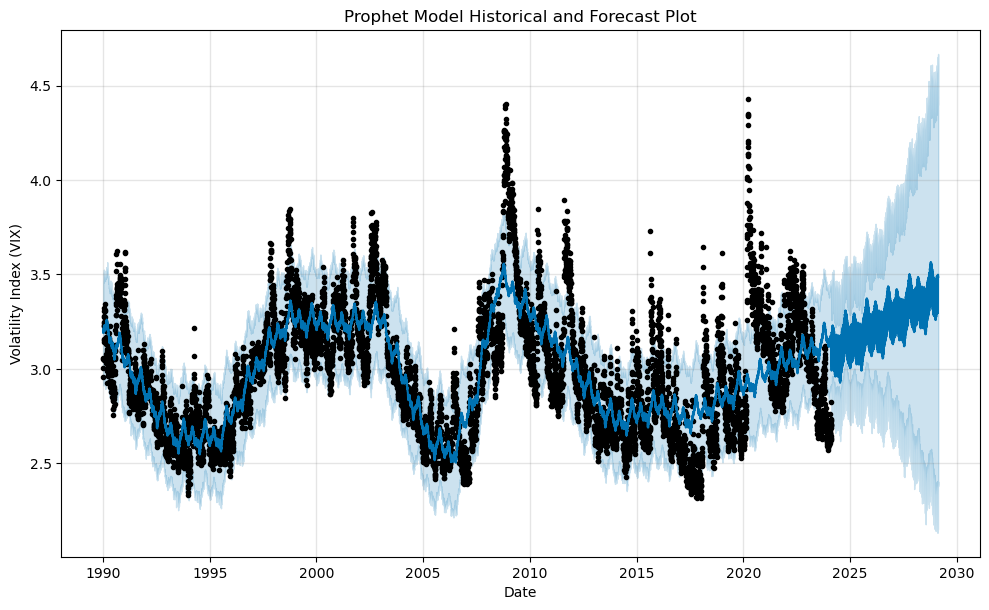

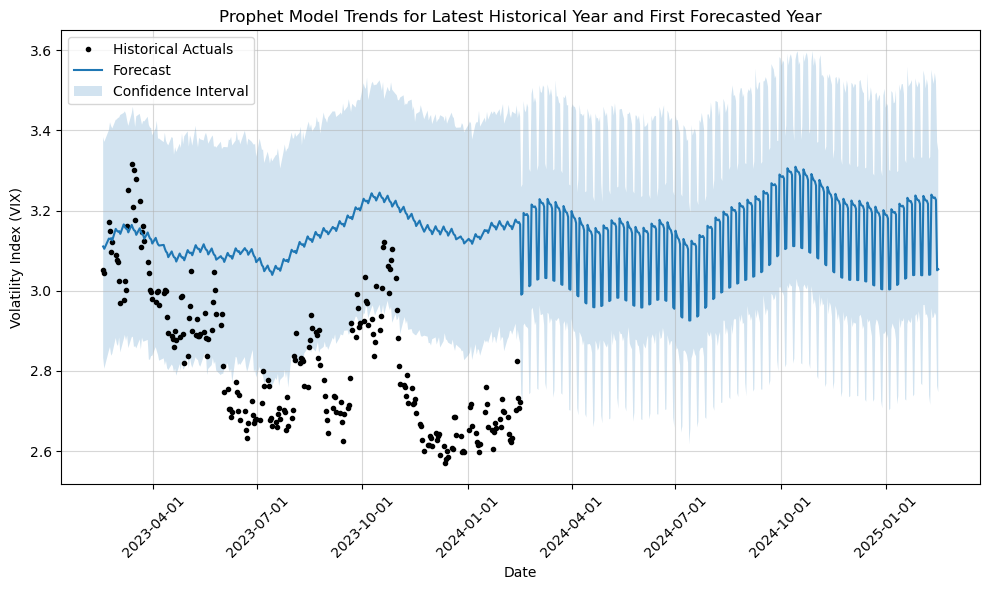

     horizon       mse      rmse       mae      mape     mdape     smape  \
0    37 days  0.095137  0.308443  0.207439  0.067017  0.048849  0.068369   
1    38 days  0.094912  0.308078  0.207560  0.067100  0.049251  0.068419   
2    39 days  0.093998  0.306591  0.206828  0.066898  0.049251  0.068180   
3    40 days  0.093908  0.306445  0.207124  0.067021  0.049375  0.068312   
4    41 days  0.094935  0.308115  0.208566  0.067485  0.049448  0.068803   
..       ...       ...       ...       ...       ...       ...       ...   
324 361 days  0.194616  0.441153  0.342278  0.115326  0.095725  0.114848   
325 362 days  0.195507  0.442161  0.343047  0.115472  0.095991  0.115101   
326 363 days  0.195714  0.442396  0.343558  0.115583  0.095991  0.115239   
327 364 days  0.195899  0.442605  0.343868  0.115656  0.096847  0.115307   
328 365 days  0.197019  0.443868  0.344626  0.115895  0.097090  0.115585   

     coverage  
0    0.605830  
1    0.604030  
2    0.604521  
3    0.605096  
4    0.

In [94]:
%matplotlib inline
# Removing the Unnecessary Columns from the Analysis
stock_data_prophet = stock_data_final_standardized[['dt', 'vix']]

print(pht.prophet_model(stock_data_prophet, 1827, '730 days', '180 days', '365 days'))

## Random Forest

In [87]:
stock_data.head()

,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002,1990,1
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010,1990,1
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013,1990,1
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012,1990,1
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009,1990,1


In [95]:
stock_data_final.head()

,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002,1990,NaN
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010,1990,NaN
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013,1990,NaN
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012,1990,NaN
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009,1990,NaN


In [97]:
# Extracting the Year and Month from the Observation Date
stock_data['Year'] = stock_data['dt'].dt.year
stock_data['Month'] = stock_data['dt'].dt.month

# Replacing the Month Words with Month Numbers
month_replacement = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Apply the mapping
unemployment_unpivot['Month'] = unemployment_unpivot['Month'].map(month_replacement)

# Merging the two DataFrames Together
stock_data_final = pd.merge(stock_data, unemployment_unpivot, on = ['Year', 'Month'], how = 'left')

#RANDOM FOREST REGRESSOR MODEL
# Defining Feature Columns and Target Variable
feature_cols = [
    'sp500',
    'sp500_volume',
    'djia',
    'hsi',
    'ads',
    'us3m',
    'joblessness',
    'epu',
    'GPRD',
    'Unemployment Percent'
]

x=stock_data_final[feature_cols]
y=stock_data_final['vix']

# Splitting the Data into Training and Testing Sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
mlt.random_forest(x_train, x_test, y_train, y_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters found:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Random Forest MSE: 2.0961
Random Forest R^2: 0.9647


## Ridge

In [98]:
# split train/test data
# y = stock_data['vix'].to_numpy()
y = stock_data_final['vix'].to_numpy()
jobless = stock_data_final['joblessness'].to_numpy().reshape(-1, 1)
us3m   = stock_data_final['us3m'].to_numpy().reshape(-1, 1)\
# one split on indices so everything stays aligned,
idx = np.arange(len(y))
idx_train, idx_test = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
# slice all arrays with the SAME indices
X_unemployment_train = jobless[idx_train]
X_unemployment_test  = jobless[idx_test]

X_bond_train = us3m[idx_train]
X_bond_test  = us3m[idx_test]
X_bond_jobless_train = np.hstack([X_unemployment_train, X_bond_train])
X_bond_jobless_test  = np.hstack([X_unemployment_test, X_bond_test])

y_train = y[idx_train]
y_test  = y[idx_test]

In [99]:
unemployment_ridge = Ridge()
bond_ridge = Ridge()
bond_unemployment_ridge = Ridge()
print(y_train)
batch_args = {
    unemployment_ridge: (X_unemployment_train, X_unemployment_test, 'Unemployment Ridge Model'),
    bond_ridge: (X_bond_train, X_bond_test, 'Bond Yield Ridge Model'),
    bond_unemployment_ridge : (X_bond_jobless_train, X_bond_jobless_test, 'Bond Yield Ridge & Unemployment Model')
}
mlt.batch_ridge(batch_args, y_train, y_test)

[12.49 11.43 17.39 ... 17.43 13.1  16.36]
Begining Batch Model Traing
------------------------------------------------
Starting training for Unemployment Ridge Model
Model results for Unemployment Ridge Model
Coefficients: [2.15795096]
Intercept: 14.215560395707142
MSE: 53.525276053137674
R^2: 0.09736845188931198
---------------------------------------------
Starting training for Bond Yield Ridge Model
Model results for Bond Yield Ridge Model
Coefficients: [-0.35865991]
Intercept: 20.538910007562855
MSE: 58.61932063957282
R^2: 0.01146426436799819
---------------------------------------------
Starting training for Bond Yield Ridge & Unemployment Model
Model results for Bond Yield Ridge & Unemployment Model
Coefficients: [ 2.10096177 -0.23962026]
Intercept: 14.995963319775434
MSE: 53.17807758550244
R^2: 0.10322348550057481
---------------------------------------------


## ARIMA

In [100]:
# get adfuller results
vix = stock_data_final['vix']
print("ADF on original VIX:")
print(arima.adf_test(vix))
#Check Stationarity using ADF - check if stationary or not, stationary if p-value < 0.05
# First difference for d=1 candidate to make stationary if needed
vix_diff = vix.diff().dropna()
print("\nADF on first-differenced VIX:")
print(arima.adf_test(vix_diff))

#Train Test Split

stock_data_final['dt'] = pd.to_datetime(stock_data_final['dt'])
stock_data_final = stock_data_final.set_index('dt')
split_idx = int(len(vix) * 0.8)
vix_train = vix.iloc[:split_idx]
vix_test = vix.iloc[split_idx:]
print(vix_train.index)

ADF on original VIX:
ADF Statistic: -6.899604939371045
p-value: 1.292177329968471e-09
Critical Values:
   1%: -3.431111851400023
   5%: -2.8618766868939542
   10%: -2.5669492135057643
None

ADF on first-differenced VIX:
ADF Statistic: -19.056078462587728
p-value: 0.0
Critical Values:
   1%: -3.4311139875737906
   5%: -2.8618776308171947
   10%: -2.566949715963274
None
RangeIndex(start=0, stop=6877, step=1)


### Stats Models ARIMA

In [101]:
arima_preds, fitted_values = arima.arima(vix_train, vix_test)

                               SARIMAX Results                                
Dep. Variable:                    vix   No. Observations:                 6877
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -12588.090
Date:                Sat, 13 Dec 2025   AIC                          25184.180
Time:                        22:05:45   BIC                          25211.524
Sample:                             0   HQIC                         25193.611
                               - 6877                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5851      1.424     13.756      0.000      16.795      22.376
ar.L1          0.9850      0.001    936.145      0.000       0.983       0.987
ma.L1         -0.1064      0.006    -19.065      0.0

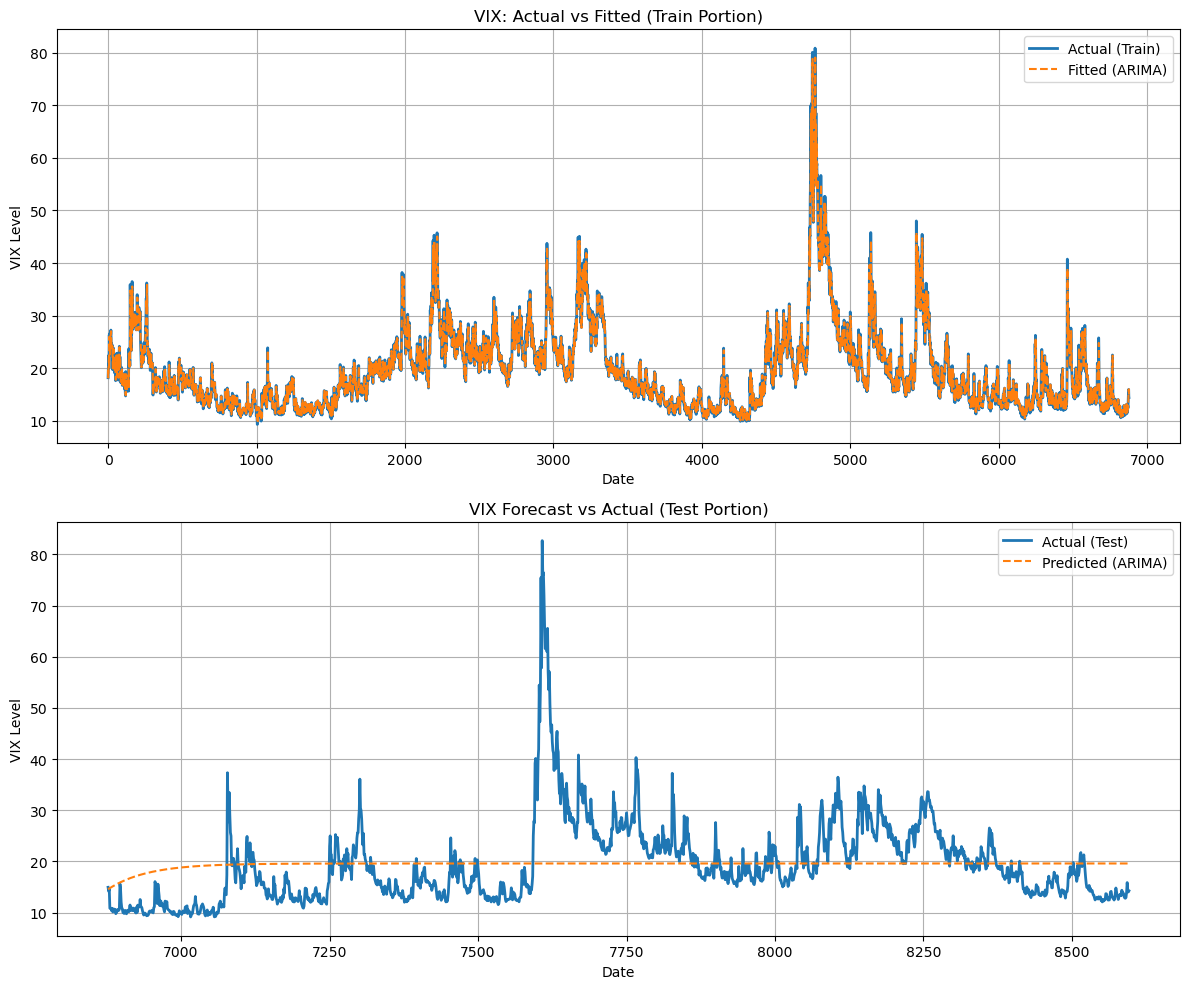

In [102]:
arima.plot_arima(vix_train, vix_test, arima_preds, fitted_values)

In [103]:
arima.arima_eval(vix_test, arima_preds)


ARIMA MAE:  5.666
ARIMA RMSE: 7.952


### Pmdarina Auto ARIMA

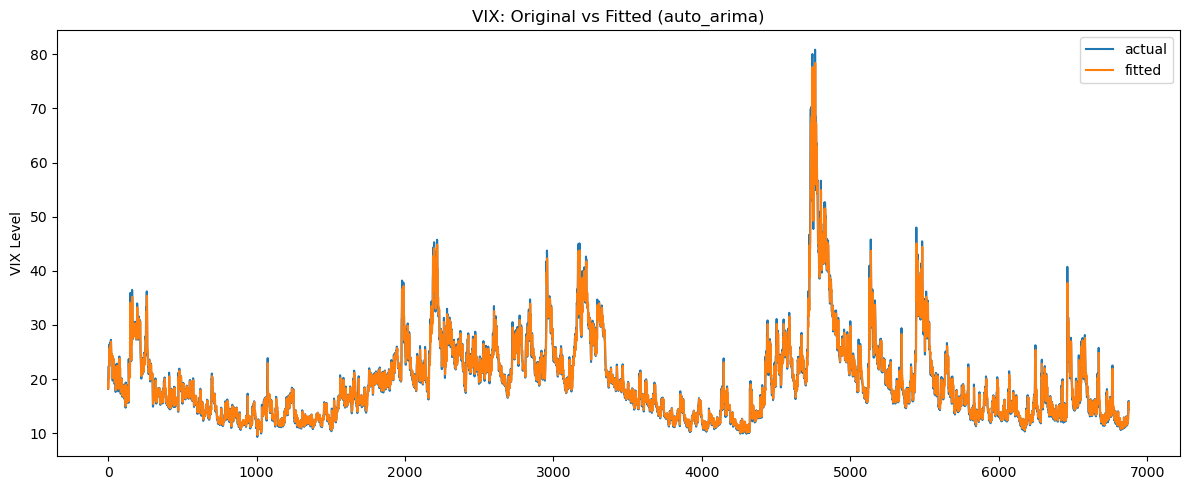

In [104]:
auto_model = arima.fit_auto_arima_model(vix_train, trace=False)

vix_fitted = arima.get_in_sample_fitted(auto_model, index=vix_train.index)
arima.plot_fitted(vix_train, vix_fitted)



In [105]:
forecast_series, conf_int_df = arima.forecast_future(
    auto_model,
    last_index=vix.index[-1],
    n_periods=250,
    freq="B"
)
arima.plot_forecast(vix, forecast_series, conf_int_df, history_days=250)

TypeError: unsupported operand type(s) for +: 'int' and 'Timedelta'

Note the large 95% confidence interval we see in the figure above. This indicates large uncertainty and implies the models forecast is a weak prediction.